#**Unsupervised pre-training**

*Students:* --Valentina Barletta (Deep Learning) valentina.barletta@edu.unito.it --Sara De Benedetti (Reti Neurali) sara.debenedetti493@edu.unito.it

# Encoder with Softmax


Importing Modules

In [1]:
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import torchvision
from statistics import mean
import numpy as np

from torchsummary import summary
from tqdm import tqdm

import os
import time

#path_data = 'MyDrive/Progetto Deep/Data/'
#model_path = '/content/drive/MyDrive/Progetto Deep/Data/model.pth'
#model_path = '/content/drive/MyDrive/Progetto Deep/Data/model_sparse.pth'


#from google.colab import drive
#drive.mount('/content/drive')

#subject = 'EncoderWithSoftmax'

Get the computation device

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)                                        # Check which device we got

cpu


## Our net: Pretrained Convolutional Encoder with Softmax

 Here it's represented the architecture of our Convolutional Autoencoder Neural Network pretrained.

In [3]:
input_dim = (28 * 28)
hidden_dim = 10
out_dim = 10

class Autoencoder(nn.Module):
    def __init__(self, input_dim, out_dim):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=1, padding=1),  # 28 x 28 x 1 -> 28 x 28 x 8
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # 28 x 28 x 8 -> 14 x 14 x 8
                                    nn.Conv2d(8, 4, kernel_size=3, padding=1),  # 14 x 14 x 8 -> 14 x 14 x 4
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2, padding=0)) # 14 x 14 x 4 -> 7 x 7 x 4


        # Decoder
        self.decoder = nn. Sequential(nn.Conv2d(4, 4, kernel_size=3, padding=1),  # 7 x 7 x 4 -> 7 x 7 x 4
                                      nn.ReLU(),
                                      nn.Upsample(scale_factor=2, mode='nearest'),  # 7 x 7 x 4 -> 14 x 14 x 4
                                      nn.Conv2d(4, 8, kernel_size=3, padding=1),  # 14 x 14 x 4 -> 14 x 14 x 8
                                      nn.ReLU(),
                                      nn.Upsample(scale_factor=2, mode='nearest'),  # 14 x 14 x 8 -> 28 x 28 x 8
                                      nn.Conv2d(8, 1, kernel_size=3, padding=1))  # 28 x 28 x 8 -> 28 x 28 x 1


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


pret_autoenc = Autoencoder(input_dim, out_dim).to(device)

Restoring the model

In [4]:
pret_autoenc.load_state_dict(torch.load("FashionMNIST_sparse_vs1.pth"))
# pretrained_autoencoder.eval()

<All keys matched successfully>

In this section, we will define our neural network made by our pretrained encoder combined with a softmax layer.

In [5]:
class EncoderWithSoftmax(nn.Module):
    def __init__(self, pretrained_autoencoder):
        super(EncoderWithSoftmax, self).__init__()

        # Extraction of the encoder from the pretrained autoencoder
        self.encoder = pretrained_autoencoder.encoder
        
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Add the softmax layer
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=4 * 7 * 7, out_features=10)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.linear(x)
        x = self.softmax(x)
        return x

## Some Helper Functions

In [6]:
def accuracy(y_pred, y):

    pred = y_pred.detach().argmax(dim=1)
    corrects = (pred == y)
    accuracy = (corrects.sum()/corrects.size(0)).float()

    return accuracy


def evaluate(model, train_loader, test_loader):

  # initialize the accuracy as 0

    acc_train, acc_test = 0, 0
    running_loss = 0.0

    with torch.no_grad():

        for x_train, y_train in train_loader:

            x_train, y_train = x_train.to(device), y_train.to(device)        # remember that we need to load our data into the GPUs

            out = model(x_train).squeeze()
            acc_train += accuracy(out, y_train)

        for x_test, y_test in test_loader:

            x_test, y_test = x_test.to(device), y_test.to(device)

            out = model(x_test).squeeze()
            loss = loss_function(out, y_test)
            running_loss += loss.item()
            acc_test += accuracy(out, y_test)
            
        val_loss = running_loss / len(test_loader)
        acc_train, acc_test = acc_train / len(train_loader), acc_test / len(test_loader)

    return float(acc_train.detach()) * 100, float(acc_test.detach()) * 100, val_loss


def train(model, x, y, loss_function, optimizer):
    model.train()
    out = model(x).squeeze()
    
    loss = loss_function(out, y)

    optimizer.zero_grad()
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

    optimizer.step()
    return float(loss)

**Loss Function and Optimizer**

For the loss function, we will use `CrossEntropyLoss` (Cross Entropy Loss).
The optimizer is going to be `Adam` with a learning rate of 0.001.

In [7]:
loss_function = nn.CrossEntropyLoss()

Prepare the Data

In [8]:
n_train = 8000
n_test = 350

batch_size_train = 16
batch_size_test = 32

transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])

## TEST SET

dataset_test =  torchvision.datasets.MNIST('./files/', train=False, download=True, transform=transform)

dataset_test.data, dataset_test.targets = dataset_test.data[n_train:(n_train + n_test)], dataset_test.targets[n_train:(n_train + n_test)]
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size = batch_size_test, shuffle = False)

Since we want to derive how the accuracy changes as the size of the training dataset decreases, here there is the code which trains a neural network on the MNIST dataset, adjusting the size of the training dataset and for each iteration of the loop.



In [9]:
old_acc = []
old_train = []
old_test = []

ratio = 50
EPOCHS = 100
n_runs = 3

for j in range(n_runs):
    
    ACCURACY_matrix = []
    TrainLOSS_matrix = []
    TestLOSS_matrix = []
    
    print(f"Run Number: {j+1}")
    
    for i in range (1, ratio+1):

        train_losses = []
        test_losses = []
        test_accuracies = []

        # Set the datasetsize
        n_train_loop = int(n_train * i / ratio)
        #batch_size_train_loop = int(batch_size_train * i / ratio)

        # Create the train dataset and the train loader 
        dataset_train =  torchvision.datasets.MNIST('./files/', train = False, download = True, transform = transform)
        dataset_train.data, dataset_train.targets = dataset_train.data[:n_train_loop], dataset_train.targets[:n_train_loop]
        train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size_train, shuffle = True, drop_last = True)

        # Call our Net
        model = EncoderWithSoftmax(pret_autoenc).to(device)

        #Set the Optimazer
        optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

        for epoch in range(1,EPOCHS+1):
            train_loss = 0

            for x_train, y_train in train_loader:
                x_train, y_train = x_train.to(device), y_train.to(device)
                loss = train(model, x_train, y_train, loss_function, optimizer)
                train_loss += loss

            train_loss /= len(train_loader)                    # we divide by the number of batches
            train_losses.append(train_loss)

            train_acc, test_acc, test_loss = evaluate(model, train_loader, test_loader)
            test_accuracies.append(test_acc)
            test_losses.append(test_loss)

            if epoch % 25 == 0:
                print("Epoch:", epoch, "Loss:", float(train_loss), "Test Loss:", test_loss, "data:", len(dataset_train.data), "train_acc", train_acc, "test_acc", test_acc)

        # Save in ACCURACY_matrix
        ACCURACY_matrix.append(test_accuracies)
        TrainLOSS_matrix.append(train_losses)
        TestLOSS_matrix.append(test_losses)

    if j == 0:

        old_acc = ACCURACY_matrix
        old_train = TrainLOSS_matrix
        old_test = TestLOSS_matrix

    else:

        # For old_acc and ACCURACY_matrix
        old_acc = [[old_acc[row][col] + ACCURACY_matrix[row][col] for col in range(len(old_acc[0]))] for row in range(len(old_acc))]

        # For old_train and TrainLOSS_matrix
        old_train = [[old_train[row][col] + TrainLOSS_matrix[row][col] for col in range(len(old_train[0]))] for row in range(len(old_train))]

        # For old_test and TestLOSS_matrix
        old_test = [[old_test[row][col] + TestLOSS_matrix[row][col] for col in range(len(old_test[0]))] for row in range(len(old_test))]
        

    print("\n")

Run Number: 1
Epoch: 25 Loss: 2.1559502601623537 Test Loss: 2.1885465275157583 data: 160 train_acc 48.124998807907104 test_acc 41.68560802936554
Epoch: 50 Loss: 2.0348177790641784 Test Loss: 2.0950630578127774 data: 160 train_acc 60.00000238418579 test_acc 50.852274894714355
Epoch: 75 Loss: 1.95867600440979 Test Loss: 2.0451673811132256 data: 160 train_acc 63.749998807907104 test_acc 51.42045617103577
Epoch: 100 Loss: 1.9184184074401855 Test Loss: 2.0200827555222944 data: 160 train_acc 64.3750011920929 test_acc 51.70454382896423
Epoch: 25 Loss: 2.0642725586891175 Test Loss: 2.1195166327736596 data: 320 train_acc 50.93749761581421 test_acc 45.113638043403625
Epoch: 50 Loss: 1.9548583209514618 Test Loss: 2.0438824783671987 data: 320 train_acc 60.624998807907104 test_acc 49.39393997192383
Epoch: 75 Loss: 1.8970034539699554 Test Loss: 2.0090289657766167 data: 320 train_acc 65.3124988079071 test_acc 50.265151262283325
Epoch: 100 Loss: 1.8513364911079406 Test Loss: 1.9827832091938367 data: 3

Epoch: 25 Loss: 1.7971668720245362 Test Loss: 1.8137050650336526 data: 2720 train_acc 71.875 test_acc 70.83333134651184
Epoch: 50 Loss: 1.7065876897643595 Test Loss: 1.7466500455682927 data: 2720 train_acc 80.47794103622437 test_acc 76.26894116401672
Epoch: 75 Loss: 1.6811388184042537 Test Loss: 1.7439259832555598 data: 2720 train_acc 81.76470398902893 test_acc 74.28030371665955
Epoch: 100 Loss: 1.6666743383688085 Test Loss: 1.7154363068667324 data: 2720 train_acc 83.01470875740051 test_acc 77.70833373069763
Epoch: 25 Loss: 1.7921909067365858 Test Loss: 1.8084393414584072 data: 2880 train_acc 71.94444537162781 test_acc 71.98863625526428
Epoch: 50 Loss: 1.7027685152159797 Test Loss: 1.7450180487199263 data: 2880 train_acc 80.69444298744202 test_acc 75.70075988769531
Epoch: 75 Loss: 1.6779950201511382 Test Loss: 1.7268525903875178 data: 2880 train_acc 82.08333253860474 test_acc 77.12121605873108
Epoch: 100 Loss: 1.664101450973087 Test Loss: 1.719162648374384 data: 2880 train_acc 82.60416

Epoch: 25 Loss: 1.667356749014421 Test Loss: 1.6957830082286487 data: 5280 train_acc 86.60984635353088 test_acc 83.14393758773804
Epoch: 50 Loss: 1.6150827035759434 Test Loss: 1.6431340087543835 data: 5280 train_acc 88.92045617103577 test_acc 85.98484396934509
Epoch: 75 Loss: 1.595037869973616 Test Loss: 1.6215188178149136 data: 5280 train_acc 89.73484635353088 test_acc 87.70833611488342
Epoch: 100 Loss: 1.5848905606703325 Test Loss: 1.6205194213173606 data: 5280 train_acc 90.77651500701904 test_acc 86.85606122016907
Epoch: 25 Loss: 1.662724912517211 Test Loss: 1.6878358234058728 data: 5440 train_acc 87.05882430076599 test_acc 85.41666269302368
Epoch: 50 Loss: 1.6109553158283234 Test Loss: 1.6462164250287143 data: 5440 train_acc 89.22793865203857 test_acc 85.41666269302368
Epoch: 75 Loss: 1.592175255803501 Test Loss: 1.6276102607900447 data: 5440 train_acc 90.33088088035583 test_acc 86.85606122016907
Epoch: 100 Loss: 1.5816442121477687 Test Loss: 1.6114079410379583 data: 5440 train_acc

Epoch: 100 Loss: 1.5674766212701798 Test Loss: 1.5746776190671055 data: 7680 train_acc 91.82291626930237 test_acc 91.15530252456665
Epoch: 25 Loss: 1.6302168152770218 Test Loss: 1.623137506571683 data: 7840 train_acc 88.25255036354065 test_acc 88.27651739120483
Epoch: 50 Loss: 1.589958148829791 Test Loss: 1.5952955809506504 data: 7840 train_acc 90.52295684814453 test_acc 89.4318163394928
Epoch: 75 Loss: 1.5748316526412964 Test Loss: 1.5781711339950562 data: 7840 train_acc 91.32652878761292 test_acc 91.4393961429596
Epoch: 100 Loss: 1.5661220370506754 Test Loss: 1.5708498846400867 data: 7840 train_acc 91.73469543457031 test_acc 91.42045378684998
Epoch: 25 Loss: 1.6294953496456146 Test Loss: 1.627580295909535 data: 8000 train_acc 88.62500190734863 test_acc 88.57954144477844
Epoch: 50 Loss: 1.5902229866981505 Test Loss: 1.5855833725495772 data: 8000 train_acc 90.6000018119812 test_acc 90.87121486663818
Epoch: 75 Loss: 1.5750273752212525 Test Loss: 1.5723669637333264 data: 8000 train_acc 9

Epoch: 75 Loss: 1.6864760884216854 Test Loss: 1.7341815124858508 data: 2240 train_acc 82.00892806053162 test_acc 77.12121605873108
Epoch: 100 Loss: 1.6712997555732727 Test Loss: 1.7283526008779353 data: 2240 train_acc 82.58928656578064 test_acc 76.26894116401672
Epoch: 25 Loss: 1.8069556721051534 Test Loss: 1.8222190575166182 data: 2400 train_acc 71.83333039283752 test_acc 70.26515007019043
Epoch: 50 Loss: 1.7138835207621257 Test Loss: 1.7640311176126653 data: 2400 train_acc 79.83333468437195 test_acc 73.99621605873108
Epoch: 75 Loss: 1.6851548568407695 Test Loss: 1.730114763433283 data: 2400 train_acc 81.87500238418579 test_acc 76.83712244033813
Epoch: 100 Loss: 1.6697890528043111 Test Loss: 1.7247367121956565 data: 2400 train_acc 82.62500166893005 test_acc 77.42424011230469
Epoch: 25 Loss: 1.8039553858339787 Test Loss: 1.8222027691927822 data: 2560 train_acc 72.3437488079071 test_acc 70.28408646583557
Epoch: 50 Loss: 1.7247417770326137 Test Loss: 1.7523088238456033 data: 2560 train_a

Epoch: 50 Loss: 1.6198019548257192 Test Loss: 1.6696538166566328 data: 4800 train_acc 88.95833492279053 test_acc 83.1250011920929
Epoch: 75 Loss: 1.5989832496643066 Test Loss: 1.6523714607412165 data: 4800 train_acc 89.89583253860474 test_acc 84.84848141670227
Epoch: 100 Loss: 1.5876477837562561 Test Loss: 1.6323855898597024 data: 4800 train_acc 90.43750166893005 test_acc 85.71969866752625
Epoch: 25 Loss: 1.6703182343513734 Test Loss: 1.70973539352417 data: 4960 train_acc 86.22983694076538 test_acc 81.95075988769531
Epoch: 50 Loss: 1.6186772919470265 Test Loss: 1.6629929217425259 data: 4960 train_acc 88.87096643447876 test_acc 84.5643937587738
Epoch: 75 Loss: 1.598486993389745 Test Loss: 1.645983186635104 data: 4960 train_acc 90.02016186714172 test_acc 85.41666269302368
Epoch: 100 Loss: 1.5865519412102238 Test Loss: 1.6371906020424583 data: 4960 train_acc 90.34274220466614 test_acc 84.84848141670227
Epoch: 25 Loss: 1.6722560789436103 Test Loss: 1.7058221101760864 data: 5120 train_acc 8

Epoch: 25 Loss: 1.6293085660623468 Test Loss: 1.641563805666837 data: 7360 train_acc 88.5054349899292 test_acc 86.28787994384766
Epoch: 50 Loss: 1.5925174150777899 Test Loss: 1.6027205207131126 data: 7360 train_acc 90.3668463230133 test_acc 89.73484635353088
Epoch: 75 Loss: 1.577479074312293 Test Loss: 1.5841579870744185 data: 7360 train_acc 91.11412763595581 test_acc 90.30303359031677
Epoch: 100 Loss: 1.5684237060339554 Test Loss: 1.5811269933527166 data: 7360 train_acc 91.7119562625885 test_acc 89.73484635353088
Epoch: 25 Loss: 1.6302701556936223 Test Loss: 1.636231086470864 data: 7520 train_acc 88.56382966041565 test_acc 87.99242377281189
Epoch: 50 Loss: 1.592056169154796 Test Loss: 1.5929649418050593 data: 7520 train_acc 90.29255509376526 test_acc 90.01893997192383
Epoch: 75 Loss: 1.5772204295117804 Test Loss: 1.5796704292297363 data: 7520 train_acc 91.1436140537262 test_acc 90.30303359031677
Epoch: 100 Loss: 1.568196518116809 Test Loss: 1.5689974156293003 data: 7520 train_acc 91.8

Epoch: 25 Loss: 1.8715501288572947 Test Loss: 1.9076261628757825 data: 1920 train_acc 64.89583253860474 test_acc 61.09848618507385
Epoch: 50 Loss: 1.7376203139623005 Test Loss: 1.7760532769289883 data: 1920 train_acc 78.80208492279053 test_acc 73.99621605873108
Epoch: 75 Loss: 1.7004636416832606 Test Loss: 1.7543865767392246 data: 1920 train_acc 81.45833611488342 test_acc 74.56439733505249
Epoch: 100 Loss: 1.6804527153571447 Test Loss: 1.7387947711077603 data: 1920 train_acc 82.03125 test_acc 75.98485350608826
Epoch: 25 Loss: 1.792263404222635 Test Loss: 1.8329112421382556 data: 2080 train_acc 76.63461565971375 test_acc 70.56818008422852
Epoch: 50 Loss: 1.7172969909814688 Test Loss: 1.7732331319288774 data: 2080 train_acc 80.14423251152039 test_acc 73.71212244033813
Epoch: 75 Loss: 1.6901834359535803 Test Loss: 1.7428279790011318 data: 2080 train_acc 81.7307710647583 test_acc 74.84848499298096
Epoch: 100 Loss: 1.6742841564691984 Test Loss: 1.7295307029377331 data: 2080 train_acc 82.163

Epoch: 100 Loss: 1.5906313644515144 Test Loss: 1.6406611095775256 data: 4320 train_acc 90.43981432914734 test_acc 85.68181991577148
Epoch: 25 Loss: 1.6746704689093999 Test Loss: 1.7296355962753296 data: 4480 train_acc 86.27232313156128 test_acc 78.23863625526428
Epoch: 50 Loss: 1.6226494393178394 Test Loss: 1.6815312558954412 data: 4480 train_acc 88.70535492897034 test_acc 81.3825786113739
Epoch: 75 Loss: 1.6022812145096914 Test Loss: 1.646657716144215 data: 4480 train_acc 89.97767567634583 test_acc 85.11363863945007
Epoch: 100 Loss: 1.5901380922113146 Test Loss: 1.63304095918482 data: 4480 train_acc 90.26785492897034 test_acc 87.42424249649048
Epoch: 25 Loss: 1.6757159911353012 Test Loss: 1.7143389528447932 data: 4640 train_acc 85.23706793785095 test_acc 81.70454502105713
Epoch: 50 Loss: 1.622862842576257 Test Loss: 1.6685993996533481 data: 4640 train_acc 88.72844576835632 test_acc 83.6931824684143
Epoch: 75 Loss: 1.6018001687937768 Test Loss: 1.6544753421436658 data: 4640 train_acc 8

Epoch: 75 Loss: 1.5821811634440754 Test Loss: 1.5948900092731824 data: 6880 train_acc 90.79942107200623 test_acc 89.45075869560242
Epoch: 100 Loss: 1.5729777740877728 Test Loss: 1.584284077991139 data: 6880 train_acc 91.33720993995667 test_acc 90.30303359031677
Epoch: 25 Loss: 1.6340063406662508 Test Loss: 1.648359320380471 data: 7040 train_acc 88.25284242630005 test_acc 87.14015483856201
Epoch: 50 Loss: 1.5960249302062122 Test Loss: 1.609136332165111 data: 7040 train_acc 90.09943008422852 test_acc 87.70833611488342
Epoch: 75 Loss: 1.580455676533959 Test Loss: 1.6002146005630493 data: 7040 train_acc 90.78124761581421 test_acc 87.99242377281189
Epoch: 100 Loss: 1.5716662840409712 Test Loss: 1.5888824246146462 data: 7040 train_acc 91.66193008422852 test_acc 89.4318163394928
Epoch: 25 Loss: 1.6316134964095221 Test Loss: 1.633403561332009 data: 7200 train_acc 87.9444420337677 test_acc 88.5606050491333
Epoch: 50 Loss: 1.5940203931596544 Test Loss: 1.6120794794776223 data: 7200 train_acc 90.

Implemet the average

In [10]:
ACCURACY_matrix = [[element / n_runs for element in row] for row in old_acc]
TrainLOSS_matrix = [[element / n_runs for element in row] for row in old_train]
TestLOSS_matrix = [[element / n_runs for element in row] for row in old_test]

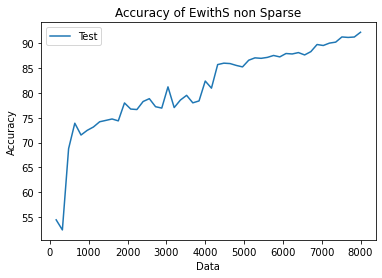

In [11]:
last_elements = [sublist[-1] for sublist in ACCURACY_matrix]

# The size of the dataset
data = [n_train * i/ratio for i in range(1, ratio + 1)]

# Plot the values
plt.plot(data, last_elements, label = "Test")
plt.xlabel("Data")
plt.ylabel("Accuracy")
plt.title('Accuracy of EwithS non Sparse')
plt.legend()
plt.show()

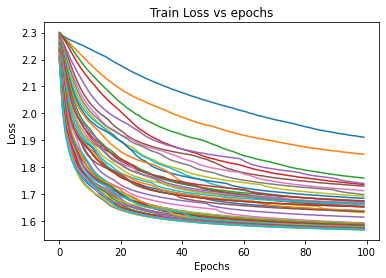

In [12]:
for i in range(len(TrainLOSS_matrix)):
    plt.plot(range(EPOCHS), TrainLOSS_matrix[i])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Train Loss vs epochs')
plt.show()

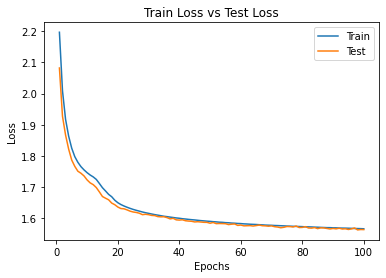

In [13]:
plt.plot(range(1, EPOCHS + 1), TrainLOSS_matrix[-1], label = "Train")
plt.plot(range(1, EPOCHS + 1), TestLOSS_matrix[-1], label = "Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Train Loss vs Test Loss')
plt.legend()
plt.show()

*Salvataggio dei dati*

In [14]:
result_dir = 'result'
os.makedirs(result_dir, exist_ok=True)

file_name1 = 'TrainLOSS_matrix_FashionMNIST_sparse.npy'
np.save(os.path.join(result_dir, file_name1), TrainLOSS_matrix)

file_name2 = 'ACCURACY_matrix_FashionMNIST_sparse.npy'
np.save(os.path.join(result_dir, file_name2), ACCURACY_matrix)

file_name3 = 'TestLOSS_matrix_FashionMNIST_sparse.npy'
np.save(os.path.join(result_dir, file_name3), TestLOSS_matrix)

**Confusion Matrix**

In [15]:
from sklearn.metrics import confusion_matrix
import numpy as np
model.eval()

all_y = []
all_predictions = []

# Iterate over the dataset
for x, y in test_loader:
    x = x.to(device)

    with torch.no_grad():
        outputs = model(x)
        _, predicted = torch.max(outputs, 1)

    all_y.extend(y.numpy())
    all_predictions.extend(predicted.cpu().numpy())

all_y = np.array(all_y)
all_predictions = np.array(all_predictions)

conf_matrix = confusion_matrix(all_y, all_predictions, normalize = "true")

print(conf_matrix.round(decimals=2))

[[0.97 0.   0.   0.   0.   0.   0.03 0.   0.   0.  ]
 [0.   0.97 0.   0.   0.   0.   0.   0.   0.03 0.  ]
 [0.03 0.   0.75 0.   0.14 0.   0.03 0.   0.06 0.  ]
 [0.   0.   0.03 0.86 0.   0.   0.   0.   0.11 0.  ]
 [0.   0.   0.   0.   0.92 0.   0.03 0.   0.03 0.03]
 [0.04 0.   0.   0.04 0.04 0.85 0.   0.   0.04 0.  ]
 [0.03 0.   0.   0.   0.   0.   0.97 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.03 0.06 0.   0.91 0.  ]
 [0.   0.   0.   0.   0.03 0.   0.   0.   0.   0.97]]


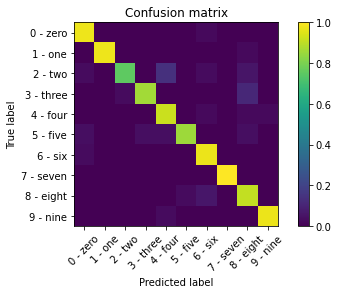

In [16]:
classes =dataset_test.classes

plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix)
plt.title("Confusion matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)


plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()